# Programming Assignment #5: Convolutional Networks
Author: Pierre Nugues

<h2>Objectives</h2>

The objectives of this assignment are to:
* Write a program to recognize flowers on images
* Learn how to manage an image data set
* Apply convolutional networks to images
* Understand class activation
* Write a short report on your experiments. This report is mandatory to pass the assignment.

## Organization

Each group will have to:
* Write Python programs to recognize the type of flowers in an image.
* Experiment different neural architectures and compare the results.

Each student will have to:
* Run at home Chollet's notebook: `chapter09_part03_interpreting-what-convnets-learn.ipynb`. You can download from https://github.com/fchollet/deep-learning-with-python-notebooks.
* Write an individual report on these experiments.

While not compulsory, I highly recommend that you use Google colab and run your program on a GPU (Unless you have a GPU on your machine). This is something you select when you run the notebook (runtime type). You will have to create a Google account for this: https://colab.research.google.com

As there are a few parameterization steps, I recommend that you start this lab as early as you can.

## Collecting a Dataset

1. Register to Kaggle (https://www.kaggle.com/) to collect the datset used in this experiment. It is free and you will have access to lots of datasets. If you do not want to register, go to step 2.
2. Download the Flower corpus:
   * Either from Kaggle if you have registered (https://www.kaggle.com/alxmamaev/flowers-recognition). 
   * Or use a local copy, `flower-recognition.zip`, in the `datasets` folder in canvas.
3. Split randomly your dataset into training, validation, and test sets: Use a 60/20/20 ratio. You will read all the file names and create a list of pairs, (file_name, category). You will then shuffle your list and save your partition of the data. To speed up the lab, you can also:
   * Start with the partition available in the canvas folder (`flower_split.zip`); or
   * Run the code in the cells below (recommended).


In [1]:
import os
import random
import shutil
from tqdm import tqdm

# The machine name. Use the name colab is you run the code from Google colab
machine_name = 'filip'

# To create the same dataset
random.seed(0)

If you use Google colab (recommended). Use the GPU accelerator

In [2]:
if machine_name == 'colab':
    from google.colab import drive
    drive.mount("/content/drive")

In [3]:
# Here write the path to your dataset
if machine_name == 'vilde':
    base = '/home/pierre/Cours/EDAN95/datasets/'
elif machine_name == 'filip':
    base = 'C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\'
elif machine_name == 'colab': # If you run your notebook with colab
    base = '/content/drive/My Drive/Colab Notebooks/'
else: # If you run your notebook on your machine
    base = 'your folder'

In [4]:
original_dataset_dir = os.path.join(base, 'flowers')
dataset = os.path.join(base, 'flowers_split')

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]
data_folders

Image types: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


['C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\flowers\\daisy',
 'C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\flowers\\dandelion',
 'C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\flowers\\rose',
 'C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\flowers\\sunflower',
 'C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\flowers\\tulip']

We build the (image, label) pairs

In [5]:
pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
pairs[:10]

[('100080576_f52e8ee070_n.jpg', 'daisy'),
 ('10140303196_b88d3d6cec.jpg', 'daisy'),
 ('10172379554_b296050f82_n.jpg', 'daisy'),
 ('10172567486_2748826a8b.jpg', 'daisy'),
 ('10172636503_21bededa75_n.jpg', 'daisy'),
 ('102841525_bd6628ae3c.jpg', 'daisy'),
 ('10300722094_28fa978807_n.jpg', 'daisy'),
 ('1031799732_e7f4008c03.jpg', 'daisy'),
 ('10391248763_1d16681106_n.jpg', 'daisy'),
 ('10437754174_22ec990b77_m.jpg', 'daisy')]

We define a split. We will run this part only once to create the partition into training, validation, and test sets.

In [6]:

random.shuffle(pairs)
img_nbr = len(pairs)
train_images = pairs[0:int(0.6 * img_nbr)]
val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
test_images = pairs[int(0.8 * img_nbr):]

# print(train_images)
print(len(train_images))
print(len(val_images))
print(len(test_images))

2590
863
864


We create the three subsets. We will run this part only once to create the partition into training, validation, and test sets.

In [124]:
if False:
    for image, label in tqdm(train_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(val_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(validation_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(test_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

## Building a Simple Convolutional Neural Network

### Architecture

Create a simple convolutional network and train a model with the training set. You can start from the architecture proposed by Chollet, Listing 8.7 (in Chollet's notebook chapter 8), and a small number of epochs. Use the `Rescaling` layer to scale your images as in the book:
```
layer.Rescaling(1.255)
```
* You will need to modify some parameters so that your network handles multiple classes.
* You will report the training and validation losses and accuracies and comment on the possible overfit.

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras import models
# from tensorflow.keras import optimizers
# from tensorflow.image import ResizeMethod

EPOCHS = 30
OPTIMIZER = 'rmsprop'
# The pretrained network
PRETRAINED = 'INCEPTION'

In [10]:
train_dataset = keras.utils.image_dataset_from_directory(
    os.path.join(base ,
        "flowers_split" ,
        "train")
    ,
    image_size=(180, 180),
    batch_size=64)

validation_dataset = keras.utils.image_dataset_from_directory(
    os.path.join(base, "flowers_split", "validation"),
    image_size=(180, 180),
    batch_size=64)

test_dataset = keras.utils.image_dataset_from_directory(
    os.path.join(base, "flowers_split", "test"),
    image_size=(180, 180),
    batch_size=64,
    shuffle=False)

Found 3632 files belonging to 5 classes.
Found 1555 files belonging to 5 classes.
Found 1563 files belonging to 5 classes.


Create the network and compile it

In [11]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.experimental.preprocessing.Rescaling(scale=1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(len(test_dataset.class_names), activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Compile your network

In [132]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [133]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_195 (Conv2D)          (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_196 (Conv2D)          (None, 41, 41, 128)       7385

Create now the data readers for the training, validation, and test sets

You will now fit your model. Before, you will define a callback as in Chollet's book.

In [134]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="lab5.keras",
        save_best_only=True,
        monitor="val_loss")
]

And fit your model

In [135]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
57/57 [==============================] - 37s 630ms/step - loss: 1.6753 - accuracy: 0.3871 - val_loss: 1.1171 - val_accuracy: 0.5531
Epoch 2/20
57/57 [==============================] - 27s 468ms/step - loss: 1.1946 - accuracy: 0.5454 - val_loss: 1.0453 - val_accuracy: 0.5859
Epoch 3/20
57/57 [==============================] - 25s 439ms/step - loss: 0.9493 - accuracy: 0.6459 - val_loss: 1.2131 - val_accuracy: 0.6064
Epoch 4/20
57/57 [==============================] - 25s 437ms/step - loss: 0.7811 - accuracy: 0.7161 - val_loss: 0.7742 - val_accuracy: 0.7228
Epoch 5/20
57/57 [==============================] - 25s 431ms/step - loss: 0.5529 - accuracy: 0.8053 - val_loss: 0.6935 - val_accuracy: 0.7846
Epoch 6/20
57/57 [==============================] - 25s 436ms/step - loss: 0.3468 - accuracy: 0.8849 - val_loss: 0.6000 - val_accuracy: 0.8302
Epoch 7/20
57/57 [==============================] - 25s 431ms/step - loss: 0.2500 - accuracy: 0.9226 - val_loss: 0.7192 - val_accuracy: 0.8354

### Analyzing the fitting performance over epochs

As in Chollet's examples, show the training and validation loss

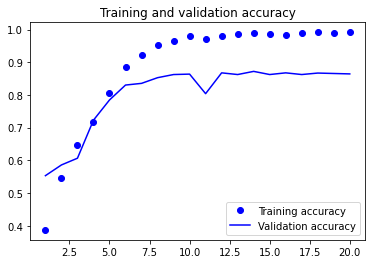

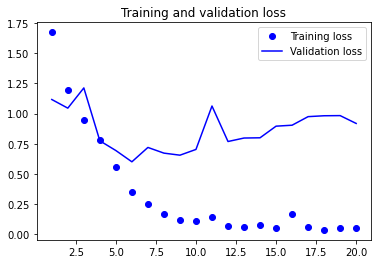

In [136]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Predicting the test set

You will now apply now your network to the test set. Read the best model from your checkpoints

In [137]:
test_model = keras.models.load_model('lab5.keras')

25/25 [==============================] - 7s 223ms/step - loss: 0.6000 - accuracy: 0.8302
Test accuracy: 0.830


Predict the test set classes. Call the matrix of prediction probabilities `Y_pred` and the predicted classes `y_pred`. While predicting, extract the annotations that you will call `y_true`.

In [138]:
Y_pred = test_model.predict(test_dataset)
y_pred = [np.argmax(probability) for probability in Y_pred]
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

In [139]:
Y_pred[:5]

array([[6.7815447e-01, 7.6908201e-02, 3.1702660e-02, 1.8529446e-01,
        2.7940238e-02],
       [9.0952605e-01, 8.3212331e-02, 4.2053387e-03, 1.3918149e-03,
        1.6644076e-03],
       [9.7430295e-01, 2.5293062e-02, 1.4152586e-04, 1.2651265e-05,
        2.4967329e-04],
       [3.8414687e-01, 5.4362267e-01, 5.6534592e-02, 6.0957007e-04,
        1.5086383e-02],
       [9.9620265e-01, 1.7725788e-03, 1.2123258e-03, 6.9900620e-04,
        1.1356914e-04]], dtype=float32)

In [140]:
y_pred[:20]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [141]:
y_true[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Evaluate your model and report the loss and accuracy using Keras `evaluate()` function. You will store them in the `test_loss_1` and `test_acc_1` variables.

In [143]:
test_loss_1, test_acc_1 = test_model.evaluate(validation_dataset)
print(f"Test accuracy: {test_acc_1:.3f}")

25/25 [==============================] - 3s 119ms/step - loss: 0.6000 - accuracy: 0.8302
Test accuracy: 0.830


In [144]:
test_loss_1, test_acc_1

(0.6000394821166992, 0.8302251100540161)

Report the accuracy as well as the classification report. Use sklearn functions this time.

In [145]:
from sklearn import metrics

print(test_acc_1)
print(metrics.classification_report(y_true, y_pred))


0.8302251100540161
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       316
           1       0.80      0.88      0.84       374
           2       0.81      0.79      0.80       282
           3       0.85      0.84      0.85       250
           4       0.89      0.75      0.82       341

    accuracy                           0.83      1563
   macro avg       0.83      0.82      0.83      1563
weighted avg       0.83      0.83      0.83      1563



Print the confusion matrix. Use a sklearn function

In [146]:
metrics.confusion_matrix(y_true, y_pred)

array([[269,  31,   7,   4,   5],
       [ 21, 330,   3,  17,   3],
       [ 20,  14, 223,   4,  21],
       [ 13,  21,   3, 211,   2],
       [ 20,  15,  38,  11, 257]], dtype=int64)

Try to improve your model by modifying some parameters and evaluate your network again.

## Using Image Augmentation

### Architecture

The flower dataset is relatively small. A way to expand such datasets is to generate artificial images by applying small transformations to existing images. Keras provides built-in layers for this. You will reuse them and apply it to the flower data set.
1. Using the network from the previous exercise, apply some transformations to your images. You can start from Chollet, Listing 8.13 (in notebook 08 also).
2. Report the training and validation losses and accuracies and comment on the possible overfit.
3. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

Write a sequence of transformation layers

In [147]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)

Define a model including these layers.

In [149]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(scale=1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(len(test_dataset.class_names), activation="softmax")(x)
model_augmented = keras.Model(inputs=inputs, outputs=outputs)


Compile your network

In [150]:
model_augmented.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [151]:
model_augmented.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_200 (Conv2D)          (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 43, 43, 64)        0   

Define a callback to save your best model

In [152]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="lab5-augmented.keras",
        save_best_only=True,
        monitor="val_loss")
]

And fit your model

In [153]:
# history_augmented = model_augmented.fit(
#     train_dataset,
#     epochs=20,
#     validation_data=validation_dataset,
#     callbacks=callbacks)

Epoch 1/20
57/57 [==============================] - 40s 678ms/step - loss: 1.6970 - accuracy: 0.3601 - val_loss: 1.2890 - val_accuracy: 0.4489
Epoch 2/20
57/57 [==============================] - 37s 638ms/step - loss: 1.2040 - accuracy: 0.5129 - val_loss: 1.1409 - val_accuracy: 0.5421
Epoch 3/20
57/57 [==============================] - 30s 532ms/step - loss: 1.0788 - accuracy: 0.5721 - val_loss: 1.0262 - val_accuracy: 0.5801
Epoch 4/20
57/57 [==============================] - 30s 531ms/step - loss: 1.0224 - accuracy: 0.6010 - val_loss: 1.0130 - val_accuracy: 0.6000
Epoch 5/20
57/57 [==============================] - 45s 792ms/step - loss: 0.9682 - accuracy: 0.6286 - val_loss: 0.8950 - val_accuracy: 0.6392
Epoch 6/20
57/57 [==============================] - 55s 962ms/step - loss: 0.9047 - accuracy: 0.6520 - val_loss: 0.8185 - val_accuracy: 0.6797
Epoch 7/20
57/57 [==============================] - 55s 968ms/step - loss: 0.8558 - accuracy: 0.6792 - val_loss: 0.7565 - val_accuracy: 0.7055

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

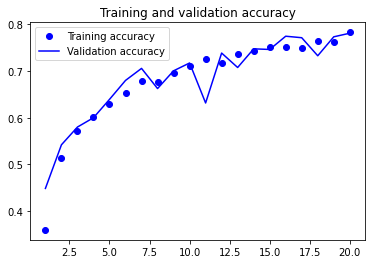

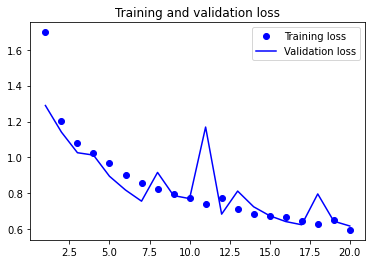

In [154]:
accuracy = history_augmented.history["accuracy"]
val_accuracy = history_augmented.history["val_accuracy"]
loss = history_augmented.history["loss"]
val_loss = history_augmented.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Predicting the test set

Load your best model

In [155]:
test_model = keras.models.load_model("lab5-augmented.keras")

Finally, run a model evaluation and store the loss and accuracy in the `test_loss_2` and `test_acc_2` variables.

In [156]:
test_loss_2, test_acc_2 = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc_2:.3f}")

25/25 [==============================] - 3s 116ms/step - loss: 0.6005 - accuracy: 0.7869
Test accuracy: 0.787


In [157]:
test_loss_2, test_acc_2

(0.6005053520202637, 0.7869482040405273)

In [158]:
Y_pred = test_model.predict(test_dataset)
y_pred = [np.argmax(probability) for probability in Y_pred]
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

metrics.confusion_matrix(y_true, y_pred)

array([[250,  29,   2,  14,  21],
       [ 29, 282,   8,  30,  25],
       [ 15,   9, 189,   5,  64],
       [  3,   8,   2, 232,   5],
       [ 11,   5,  31,  17, 277]], dtype=int64)

In [159]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       316
           1       0.85      0.75      0.80       374
           2       0.81      0.67      0.74       282
           3       0.78      0.93      0.85       250
           4       0.71      0.81      0.76       341

    accuracy                           0.79      1563
   macro avg       0.79      0.79      0.79      1563
weighted avg       0.79      0.79      0.79      1563



## Using a Pretrained Convolutional Base

### Architecture

Some research teams have trained convolutional neural networks on much larger datasets. We have seen during the lecture that the networks can model conceptual patterns as they go through the layers. This was identified by Le Cun in his first experiments [http://yann.lecun.com/exdb/lenet/](http://yann.lecun.com/exdb/lenet/). In this last part, you will train classifiers on top of a pretrained convolutional base.
1. Train your network and report the training and validation losses and accuracies.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [13]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(180, 180, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(180, 180, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 89, 89, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 89, 89, 32)   96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 89, 89, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

As in Chollet, Listing 8.20 (in Chollet's notebook 08), you will program a `get_features_and_labels()` function.

In [162]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = tf.keras.applications.inception_v3.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

The features and labels

In [163]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [164]:
train_features.shape
print(train_dataset)

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


Build a network that consists of the Inception V3 convolutional base and two dense layers.

In [166]:
inputs = keras.Input(shape=(4, 4, 2048))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)


In [167]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 4, 4, 2048)]      0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               8388864   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 1285      
Total params: 8,390,149
Trainable params: 8,390,149
Non-trainable params: 0
_________________________________________________________________


Compile your model

In [168]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Define a callback to save your best model

In [169]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="inception-v3-tip.keras",
      save_best_only=True,
      monitor="val_loss")
]

Fit your network

In [170]:
history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)


Epoch 1/30
114/114 [==============================] - 6s 46ms/step - loss: 41.6563 - accuracy: 0.6638 - val_loss: 38.8668 - val_accuracy: 0.6624
Epoch 2/30
114/114 [==============================] - 5s 44ms/step - loss: 18.7592 - accuracy: 0.7952 - val_loss: 16.9077 - val_accuracy: 0.8161
Epoch 3/30
114/114 [==============================] - 5s 45ms/step - loss: 12.0392 - accuracy: 0.8417 - val_loss: 8.9515 - val_accuracy: 0.8778
Epoch 4/30
114/114 [==============================] - 5s 40ms/step - loss: 9.1477 - accuracy: 0.8689 - val_loss: 6.8795 - val_accuracy: 0.8907
Epoch 5/30
114/114 [==============================] - 4s 39ms/step - loss: 7.1962 - accuracy: 0.8835 - val_loss: 7.6328 - val_accuracy: 0.8746
Epoch 6/30
114/114 [==============================] - 5s 40ms/step - loss: 6.2372 - accuracy: 0.8945 - val_loss: 10.1671 - val_accuracy: 0.8688
Epoch 7/30
114/114 [==============================] - 5s 48ms/step - loss: 4.9015 - accuracy: 0.9149 - val_loss: 11.7561 - val_accuracy:

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

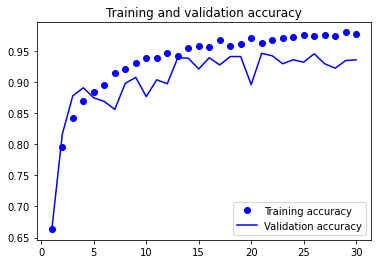

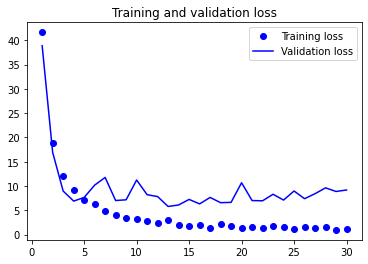

In [171]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Load your best model from the file

In [172]:
test_model = keras.models.load_model('inception-v3-tip.keras')

Evaluate your model and store the loss and accuracy in `test_loss_3`, `test_acc_3`

In [173]:
test_loss_3, test_acc_3 = test_model.evaluate(test_features, test_labels, 64)
print(f"Test accuracy: {test_acc_3:.3f}")


25/25 [==============================] - 0s 5ms/step - loss: 4.9131 - accuracy: 0.9431
Test accuracy: 0.943


In [174]:
test_loss_3, test_acc_3

(4.913136959075928, 0.94305819272995)

## Using a Pretrained Convolutional Base with Image Augmentation

### Architecture

1. Modify your program to include an image transformer. Train a new model. As a hint, use nadam or rmsprop as optimizer. Rescaling seems to lower the accuracy. Do not use it in your first attempts.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [14]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(180, 180, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(180, 180, 3))

You may want to try this first, and possibly modify it to improve the scores

In [15]:
conv_base.trainable = False

Create an image augmentation

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)


Create your model

In [17]:

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)


Compile it

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 180, 180, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388

Write a callback to save your best model

In [20]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="lab5-pretrained-augmented-2.keras",
        save_best_only=True,
        monitor="val_loss")
]

Fit the model

In [21]:
history_augmented_2 = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
57/57 [==============================] - 61s 949ms/step - loss: 60.3304 - accuracy: 0.5972 - val_loss: 70.4408 - val_accuracy: 0.6566
Epoch 2/10
57/57 [==============================] - 75s 1s/step - loss: 27.5351 - accuracy: 0.7200 - val_loss: 15.6216 - val_accuracy: 0.7871
Epoch 3/10
57/57 [==============================] - 60s 1s/step - loss: 21.3499 - accuracy: 0.7486 - val_loss: 8.8060 - val_accuracy: 0.8534
Epoch 4/10
57/57 [==============================] - 49s 855ms/step - loss: 16.9710 - accuracy: 0.7695 - val_loss: 27.4258 - val_accuracy: 0.7132
Epoch 5/10
57/57 [==============================] - 49s 868ms/step - loss: 14.5889 - accuracy: 0.7938 - val_loss: 25.7637 - val_accuracy: 0.7273
Epoch 6/10
57/57 [==============================] - 49s 853ms/step - loss: 10.7493 - accuracy: 0.8086 - val_loss: 15.0104 - val_accuracy: 0.7974
Epoch 7/10
57/57 [==============================] - 49s 868ms/step - loss: 9.0224 - accuracy: 0.8205 - val_loss: 12.1751 - val_accuracy: 

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

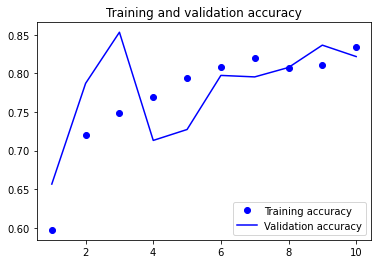

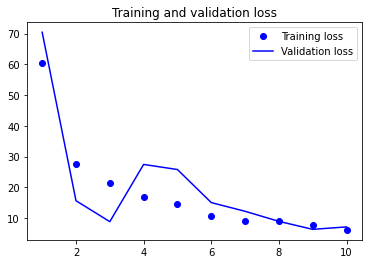

In [26]:
accuracy = history_augmented_2.history["accuracy"]
val_accuracy = history_augmented_2.history["val_accuracy"]
loss = history_augmented_2.history["loss"]
val_loss = history_augmented_2.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Load your best model

In [23]:
test_model = keras.models.load_model("lab5-pretrained-augmented-2.keras")

Evaluate it and store the loss and accuracy in `test_loss_4` and `test_acc_4`

In [27]:
test_loss_4, test_acc_4 = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc_4:.3f}")

25/25 [==============================] - 15s 604ms/step - loss: 5.0383 - accuracy: 0.8516
Test accuracy: 0.852


In [28]:
test_loss_4, test_acc_4

(5.038303375244141, 0.8515675067901611)

### Predicting the test set

Apply now your network to the test set. You will collect `y_true` and `y_pred`

In [29]:
Y_pred = test_model.predict(test_dataset)
y_pred = [np.argmax(probability) for probability in Y_pred]
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

Report the accuracy as well as the classification report. Use sklearn functions

In [31]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       316
           1       0.89      0.89      0.89       374
           2       0.97      0.62      0.76       282
           3       0.78      0.95      0.85       250
           4       0.75      0.93      0.83       341

    accuracy                           0.85      1563
   macro avg       0.87      0.85      0.85      1563
weighted avg       0.87      0.85      0.85      1563



Print the confusion matrix

In [32]:
metrics.confusion_matrix(y_true, y_pred)

array([[267,  19,   1,  22,   7],
       [  5, 332,   1,  27,   9],
       [  3,   9, 176,   9,  85],
       [  0,   7,   1, 238,   4],
       [  2,   7,   3,  11, 318]], dtype=int64)

## Passing the Assignment

To pass the assignment, you need to reach an accuracy of 75 (even 80 ideally) with your best network.

In [ ]:
(test_loss_1, test_acc_2), (test_loss_2, test_acc_2), (test_loss_3, test_acc_3), (test_loss_4, test_acc_4)

((0.6000394821166992, 0.7869482040405273),
 (0.6005053520202637, 0.7869482040405273),
 (4.913136959075928, 0.94305819272995),
 (5.580825328826904, 0.8675623536109924))

## Report

You will write a short report of about two pages on your experiments:
1. You will describe all the architectures you designed and the results you obtained. You will summarize the results in a table. Your description should be one-page long;
2. You will run Chollet's notebook chapter09_part3 and read the article _Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization_ by Selvaraju et al. From this, you will reformulate and comment the paragraph on _Visualizing heatmaps of class activation_ in the notebook. Your analysis should be about one-page long.
3. You will run it on one of your flower images.

You will submit your report as well as your notebook through Canvas.